In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

2023-04-19 04:55:22.615271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 04:55:23.709579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-19 04:55:23.709687: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-19 04:55:23.709699: W 

MONAI version: 1.1.0
Numpy version: 1.21.5
Pytorch version: 1.12.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.2
gdown version: 4.6.0
TorchVision version: 0.13.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.26.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
path = '/braindat/lab/chenyd/LOGs/Neurips23_imgSSL/barlowTwins0414_final2/checkpoint_29999.pth'
weight = torch.load(path)

In [8]:
weight['model'].keys()

odict_keys(['module.backbone.conv1.weight', 'module.backbone.bn1.weight', 'module.backbone.bn1.bias', 'module.backbone.bn1.running_mean', 'module.backbone.bn1.running_var', 'module.backbone.bn1.num_batches_tracked', 'module.backbone.layer1.0.conv1.weight', 'module.backbone.layer1.0.bn1.weight', 'module.backbone.layer1.0.bn1.bias', 'module.backbone.layer1.0.bn1.running_mean', 'module.backbone.layer1.0.bn1.running_var', 'module.backbone.layer1.0.bn1.num_batches_tracked', 'module.backbone.layer1.0.conv2.weight', 'module.backbone.layer1.0.bn2.weight', 'module.backbone.layer1.0.bn2.bias', 'module.backbone.layer1.0.bn2.running_mean', 'module.backbone.layer1.0.bn2.running_var', 'module.backbone.layer1.0.bn2.num_batches_tracked', 'module.backbone.layer1.0.conv3.weight', 'module.backbone.layer1.0.bn3.weight', 'module.backbone.layer1.0.bn3.bias', 'module.backbone.layer1.0.bn3.running_mean', 'module.backbone.layer1.0.bn3.running_var', 'module.backbone.layer1.0.bn3.num_batches_tracked', 'module.ba

In [7]:
root_dir = '/braindat/lab/chenyd/MODEL/MSD'

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [36]:
import json
with open(datasets) as json_file:
    data = json.load(json_file)
    train_files = data["training"]
    val_files = data["test"]
    labels = data['labels']

In [3]:
import nibabel as nib
import os
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    RandSpatialCropd,
)
from resunet import ResUNet
import torch.nn as nn
import argparse
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1,1,1),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=patch_size,
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        RandSpatialCropd(
            keys=["image", "label"],
            roi_size=(100,100,100),
            random_size=False,
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

In [5]:
def get_nii_data(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data.shape

data_path = sorted(glob(os.path.join('/data/ydchen/EM_pretraining_data/MSD/Task02_Heart', 'imag*', '*.nii.gz')))
for i in data_path:
    print(get_nii_data(i))

(320, 320, 130)
(320, 320, 110)
(320, 320, 120)
(320, 320, 130)
(320, 320, 100)
(320, 320, 120)
(320, 320, 120)
(320, 320, 120)
(320, 320, 90)
(320, 320, 120)
(320, 320, 122)
(320, 320, 100)
(320, 320, 110)
(320, 320, 100)
(320, 320, 110)
(320, 320, 110)
(320, 320, 120)
(320, 320, 120)
(320, 320, 109)
(320, 320, 110)
(400, 400, 180)
(320, 320, 140)
(400, 400, 180)
(320, 320, 110)
(320, 320, 137)
(320, 320, 120)
(320, 320, 100)
(320, 320, 120)
(320, 320, 100)
(320, 320, 110)


In [2]:
path = '/data/ydchen/EM_pretraining_data/MSD/Task02_Heart/imagesTs/la_002.nii.gz'
img = nib.load(path)
img = img.get_fdata()
print(img.shape)

(320, 320, 140)


In [14]:
data_dir = "/braindat/lab/chenyd/DATASET/MSD/Task01_BrainTumour/"
split_json = "dataset.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
total_len = len(datalist)
trainlist = datalist[: int(total_len * 0.9)]
val_files = datalist[int(total_len * 0.9) :]

train_ds = CacheDataset(
    data=trainlist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


In [13]:
len(datalist)

484

In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [16]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
# while global_step < max_iterations:
#     global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

In [17]:
x = torch.randn(1, 1, 96, 96, 96).cuda()
model(x).shape

torch.Size([1, 14, 96, 96, 96])

In [26]:
for batch in val_loader:
    x, y = (batch["image"], batch["label"])
    break

In [27]:
from matplotlib import pyplot as plt

In [32]:
y.unique()

tensor([0., 1., 2., 3.])

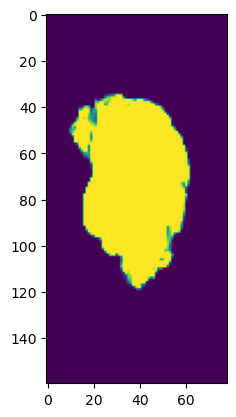

In [30]:
plt.imshow(x[0, 0, 48, :, :].cpu().numpy())

In [9]:
import os
from glob import glob
import json
import nibabel as nib

In [36]:
path = glob(os.path.join('/data/ydchen/EM_pretraining_data/MSD_json','ta*','nnUNetPlans.json'))
for i in path:
    with open(i) as json_file:
        data = json.load(json_file)
        patch_size = data['configurations']['3d_fullres']['patch_size']
        print(f'task {i.split("/")[-2]} patch size is {patch_size}')

task task7 patch size is [40, 224, 224]
task task10 patch size is [56, 192, 192]
task task5 patch size is [20, 320, 256]
task task6 patch size is [80, 192, 160]
task task3 patch size is [128, 128, 128]
task task8 patch size is [64, 192, 192]
task task1 patch size is [128, 128, 128]
task task4 patch size is [40, 56, 40]
task task2 patch size is [80, 192, 160]
task task9 patch size is [64, 192, 160]


In [37]:
print(patch_size)
patch_size = np.array(patch_size)
# permute
patch_size = patch_size[[1,2,0]]
print(tuple(patch_size))

[64, 192, 160]
(192, 160, 64)


In [21]:
patch_size[0], patch_size[1], patch_size[2] = patch_size[2], patch_size[0], patch_size[1]
patch_size

[160, 64, 192]

In [10]:
def read_nii(path):
    img = nib.load(path)
    img = img.get_fdata()
    return img

In [48]:
data_path = glob(os.path.join('/data/ydchen/EM_pretraining_data/MSD','Task03*','im*','*gz'))

In [49]:
for i in data_path:
    img = read_nii(i)
    print(f'task {i.split("/")[-3]} image shape is {img.shape}')

task Task03_Liver image shape is (512, 512, 751)
task Task03_Liver image shape is (512, 512, 366)
task Task03_Liver image shape is (512, 512, 756)
task Task03_Liver image shape is (512, 512, 129)
task Task03_Liver image shape is (512, 512, 630)
task Task03_Liver image shape is (512, 512, 517)
task Task03_Liver image shape is (512, 512, 541)
task Task03_Liver image shape is (512, 512, 333)
task Task03_Liver image shape is (512, 512, 122)
task Task03_Liver image shape is (512, 512, 826)
task Task03_Liver image shape is (512, 512, 113)
task Task03_Liver image shape is (512, 512, 629)
task Task03_Liver image shape is (512, 512, 155)
task Task03_Liver image shape is (512, 512, 696)
task Task03_Liver image shape is (512, 512, 119)
task Task03_Liver image shape is (512, 512, 861)
task Task03_Liver image shape is (512, 512, 683)
task Task03_Liver image shape is (512, 512, 677)
task Task03_Liver image shape is (512, 512, 781)
task Task03_Liver image shape is (512, 512, 836)
task Task03_Liver im

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_4338/2790395979.py:2 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_4338/2790395979.py'                         │
│                                                                                                  │
│ /tmp/ipykernel_4338/3768510918.py:3 in read_nii                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_4338/3768510918.py'                         │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/nibabel/dataobj_images.py:355 in get_fdata                │
│                                                                                                  │
│   352 │   │   # Always return requested data type                                                │
│   353 │   │   # For array proxies, will attempt to confine data array to dtype                   │
│   354 │   │   # during scaling                                                                   │
│ ❱ 355 │   │   data = np.asanyarray(self._dataobj, dtype=dtype)                                   │
│   356 │   │   if caching == 'fill':                                                              │
│   357 │   │   │   self._fdata_cache = data                                                       │
│   358 │   │   return data                                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/nibabel/arrayproxy.py:370 in __array__                    │
│                                                                                                  │
│   367 │   │   array                                                                              │
│   368 │   │   │   Scaled image data with type `dtype`.                                           │
│   369 │   │   """                                                                                │
│ ❱ 370 │   │   arr = self._get_scaled(dtype=dtype, slicer=())                                     │
│   371 │   │   if dtype is not None:                                                              │
│   372 │   │   │   arr = arr.astype(dtype, copy=False)                                            │
│   373 │   │   return arr                                                                         │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/nibabel/arrayproxy.py:337 in _get_scaled                  │
│                                                                                                  │
│   334 │   │   if np.can_cast(scl_inter, use_dtype):                                              │
│   335 │   │   │   scl_inter = scl_inter.astype(use_dtype)                                        │
│   336 │   │   # Read array and upcast as necessary for big slopes, intercepts                    │
│ ❱ 337 │   │   scaled = apply_read_scaling(self._get_unscaled(slicer=slicer), scl_slope, scl_in   │
│   338 │   │   if dtype is not None:                                                              │
│   339 │   │   │   scaled = scaled.astype(np.promote_types(scaled.dtype, dtype), copy=False)      │
│   340 │   │   return scaled                                                                      │
│                                                                                                  │
│ /opt/conda/lib/python3.7/site-packages/nibabel/arrayproxy.p

In [6]:
!nvidia-smi

Thu Apr 20 11:06:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   49C    P2   218W / 250W |   6047MiB / 11178MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 23%   

In [1]:
import os 
import torch

In [3]:
weights = torch.load('/data/ydchen/EM_pretraining_data/BarlowClip/testgenerate_then_optimize_pretrain_7000_iterations_encoder.pth',
                     map_location=torch.device('cpu'))

In [5]:
weights.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we